<a href="https://colab.research.google.com/github/dimakpa/ML_Projects/blob/main/%D0%A1%D0%BB%D1%83%D1%87%D0%B0%D0%B9%D0%BD%D1%8B%D0%B5_%D0%BB%D0%B5%D1%81_%D0%B4%D0%BB%D1%8F_%D0%BA%D0%BB%D0%B0%D1%81%D1%81%D0%B8%D1%84%D0%B8%D0%BA%D0%B0%D1%86%D0%B8%D0%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Построение случайного леса ПРИМЕР

Теория...

In [ ]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn.datasets import make_classification

import numpy as np

Генерируем данные, представляющие собой 500 объектов с 5-ю признаками

In [ ]:
classification_data, classification_labels = make_classification(n_samples=500,
                                                                 n_features=5,
                                                                 n_informative=5,
                                                                 n_classes=2,
                                                                 n_redundant=0,
                                                                 n_clusters_per_class=1, 
                                                                 random_state=23)

Про параметры https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_classification.html

Визуализируем сгенерированные данные

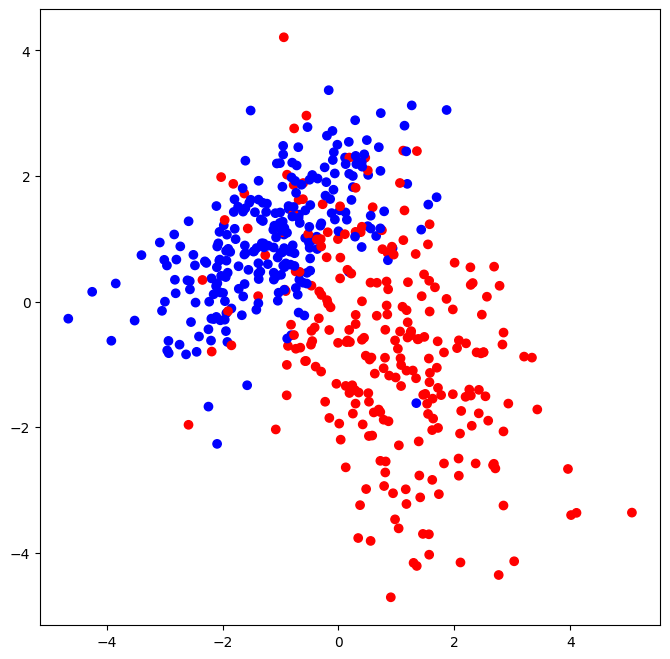

In [ ]:
colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(classification_data[:, 0], classification_data[:, 1], c=classification_labels, cmap=colors);

Реализуем генерацию N бутстрап-выборок и подмножества признаков для нахождения разбиения в узле.

Передаем данные и целевые значения, N овечает за количество подвыборок.
Возвращаем список выброк в виде кортежа бутстрапированные подвыборки


In [ ]:
np.random.seed(42)

def get_bootstrap(data, labels, N):
    n_samples = data.shape[0] # размер совпадает с исходной выборкой
    bootstrap = []

    for i in range(N):

      sample_index = np.random.randint(0, n_samples, size=n_samples)
      b_data = data[sample_index]
      b_labels = labels[sample_index]

      bootstrap.append((b_data, b_labels))

    return bootstrap  


In [ ]:
#пример работы
#get_bootstrap(classification_data, classification_labels, 2)

Теперь рассмотрим метод случайных признаков. 

Напишем функцию и будем возвращать индексы случайных признаков
На вход подается количество признаков. Самое оптимальное количество - корень из количества признаков. replace отвечает за повторения


In [ ]:
def get_subsample(len_sample):
    sample_indexes = list(range(len_sample))

    len_subsample = int(np.sqrt(len_sample))
    subsample = np.random.choice(sample_indexes, size=len_subsample, replace=False)

    return subsample

In [ ]:
get_subsample(16)

array([ 0,  1,  5, 14])

Реализация построения дерева решений

Класс узла

In [ ]:
class Node:
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index #индекс признака, по котрому ведется сравнение с порогом в этом узле
        self.t = t #значение порога
        self.true_branch = true_branch #поддерево удовлетворяющее условию в узле
        self.false_branch = false_branch #поддерево не удовлетворяющее условию в узле

Класс терминального узла (ЛИСТА)

In [ ]:
class Leaf:

    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
    def predict(self): #подсчет количества объектов разных классов
        classes = {}
        for label in self.labels:
          if label not in classes:
            classes[label] = 0
          classes[label] += 1

        
        #найдем класс, количество которого будет максимальным в этом листе и вернем его
        prediction = max(classes, key=classes.get)
        return prediction


Расчет критерия Джини. 
Подсчет количества каждого класса, а после посчет информативности каждого класса.

In [ ]:
def gini (labels):
    # подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes [label] = 0
        classes[label] += 1
    # расчет критерия
    impurity = 1
    for label in classes:
        p = classes [label] / len(labels)
        impurity -= p ** 2
    return impurity

Расчет прироста. 
Прирост информауции объединяет 3 критерия воедино.

In [ ]:
def gain(left_labels, right_labels, root_gini):
    # доля выборки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    return root_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

Разбиение датасета в узле.
Разбиение по признаку спрашиваем про пороговое значение.

In [ ]:
def split(data, labels, column_index, t):
    left = np.where(data[:, column_index] <= t) 
    right = np.where(data[:, column_index] > t)

    true_data = data[left]
    false_data = data[right]

    true_labels = labels[left]
    false_labels = labels[right]
    
    return true_data, false_data, true_labels, false_labels

Нахождение наилучшего разбиения.
Принимает данные и целевые значения. Хорошо бы чтою критерий gini стремился к 0.

In [ ]:
def find_best_split(data, labels):

    min_leaf_samples = 5
    root_gini = gini(labels)
    best_gain = 0
    best_t = None
    best_index = None

    n_features = data.shape[1]
    feature_subsample_indices = get_subsample(n_features) #выбираем случайные признаки
    for index in feature_subsample_indices:
        #будем проверять только уникальные значения признака, исключая повторения
        t_values = np.unique (data[:, index])
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

            current_gain = gain(true_labels, false_labels, root_gini)

            # выбираем порог, на котором получается максимальный прирост качества
            if current_gain > best_gain:
                best_gain, best_t, best_index = current_gain, t, index

    return best_gain, best_t, best_index

Построение дерева с помощью рекурсивной функции. Сначала ищем лучшее разбиение. Прекращаем рекурсию, если не прироста качества. Возвращаем ссылку на узел, на правое и левое.

In [ ]:
def build_tree(data, labels):
    gain, t, index = find_best_split(data, labels)
    # Базовый случай • прекращаем рекурсию, когда нет прироста в качества
    if gain == 0:
        return Leaf (data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)


    #Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

Добавим функцию формирования случайного леса. Для каждого дерева генерируем данные и добавляем в лес

In [ ]:
def random_forest(data, labels, n_trees):
    forest = []
    bootstrap = get_bootstrap(data, labels, n_trees)
    for b_data, b_labels in bootstrap:
        forest.append(build_tree(b_data, b_labels))
    return forest

Функция классификации отдельного объекта. Если лист, то достаем предсказание. Иначе рекурсивно спускаемся до листа.

In [ ]:
def classify_object(obj, node):
    # Останавливаем рекурсию, если достигли листа
    if isinstance (node, Leaf):
        answer = node.prediction
        return answer 
    
    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch) 
    else:
        return classify_object(obj, node. false_branch)

Функция формирования предсказания по выборке на одном дереве. Передаем все данные и дерево. 

In [ ]:
def predict(data, tree):

    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

Предсказание голосованием деревьев. Уже проходимся по лесу и обрабатываем каждое дерево отдельно

In [ ]:
def tree_vote(forest, data):
    # добавим предсказания всех деревьев в список
    predictions = []
    for tree in forest:
        predictions.append(predict(data, tree)) 
        # print(predictions)

    # сформируем список с предсказаниями для каждого обьекта
    predictions_per_object = list(zip(*predictions))
    # print(predictions per object)


    # выберем в качестве итогового предсказания для каждого объекта то,
    # за которое проголосовало большинство деревьев
    voted_predictions = []
    for obj in predictions_per_object:
        voted_predictions.append(max(set(obj), key=obj.count)) 
    return voted_predictions

In [ ]:
# tree_vote(my_forest_3, test_data[:5])

Разобьем выборку на обучающую и тестовую 70\30

In [ ]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(classification_data,
                                                                    classification_labels,
                                                                    test_size=0.3,
                                                                    random_state=1)

Введем функцию подсчета точности как доли правильных ответов. Поступают истинные значения и предсказанные значения. Изначально угаданных 0 штук. Если истинное значение совпадает с угаданным ++1, умножаем на 100 и получем процены

In [ ]:
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

Теперь можно строить несколько случайных лесов с разным количеством деревьев.

Построи лес из одного дерева.

In [ ]:
n_trees = 1
my_forest_1 = random_forest(train_data, train_labels, n_trees)

Получим ответы для обучающей выборки.

In [ ]:
train_answer = tree_vote(my_forest_1, train_data)

Получим ответы для тестовой выборки

In [ ]:
test_answer = tree_vote(my_forest_1, test_data)

Теперь посмотрим точность на обучающей выборке

In [ ]:
train_accuracy = accuracy_metric(train_labels, train_answer)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy: 3f}')

Точность случайного леса из 1 деревьев на обучающей выборке:  92.857143


А точность на тестовой выборке

In [ ]:
test_accuracy = accuracy_metric(test_labels, test_answer)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {test_accuracy: 3f}')

Точность случайного леса из 1 деревьев на обучающей выборке:  88.000000


Построим лес из 3 деревьев, а не из одного.

Проведем все те же манипуляции и посмотрим на результат.

In [ ]:
#3 дерева
n_trees = 3
my_forest_3 = random_forest(train_data, train_labels, n_trees)

# Ответы для тестовой и обучающей выборки
train_answer_3 = tree_vote(my_forest_3, train_data)
test_answer_3 = tree_vote(my_forest_3, test_data)


train_accuracy_3 = accuracy_metric(train_labels, train_answer_3)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_3: 3f}')

test_accuracy_3 = accuracy_metric(test_labels, test_answer_3)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {test_accuracy_3: 3f}')

Точность случайного леса из 3 деревьев на обучающей выборке:  98.285714
Точность случайного леса из 3 деревьев на обучающей выборке:  96.000000


Точность увеличилась.

Построим лес из 10 деревьев.

In [ ]:
#10 дерева
n_trees = 10
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Ответы для тестовой и обучающей выборки
train_answer_10 = tree_vote(my_forest_10, train_data)
test_answer_10 = tree_vote(my_forest_10, test_data)


train_accuracy_10 = accuracy_metric(train_labels, train_answer_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10: 3f}')

test_accuracy_10 = accuracy_metric(test_labels, test_answer_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {test_accuracy_10: 3f}')

Точность случайного леса из 10 деревьев на обучающей выборке:  99.714286
Точность случайного леса из 10 деревьев на обучающей выборке:  96.000000


Лес из 50 деревьев

In [ ]:
#10 дерева
n_trees = 50
my_forest_10 = random_forest(train_data, train_labels, n_trees)

# Ответы для тестовой и обучающей выборки
train_answer_10 = tree_vote(my_forest_10, train_data)
test_answer_10 = tree_vote(my_forest_10, test_data)


train_accuracy_10 = accuracy_metric(train_labels, train_answer_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {train_accuracy_10: 3f}')

test_accuracy_10 = accuracy_metric(test_labels, test_answer_10)
print(f'Точность случайного леса из {n_trees} деревьев на обучающей выборке: {test_accuracy_10: 3f}')

Точность случайного леса из 50 деревьев на обучающей выборке:  100.000000
Точность случайного леса из 50 деревьев на обучающей выборке:  96.000000


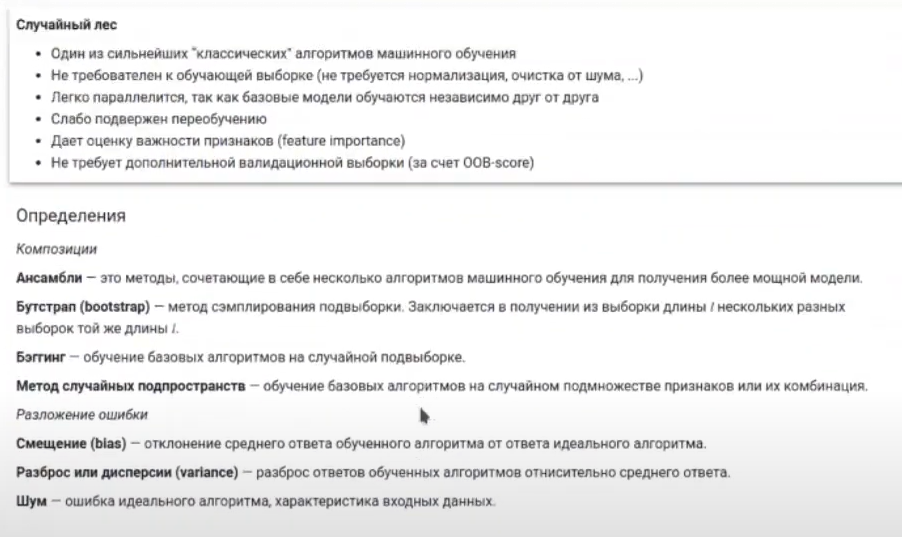